In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
import numpy as np
import os

In [ ]:
!unzip /content/drive/MyDrive/DataScotland/tiles_central-belt50000.zip > /dev/null

#Model Architectures

In [ ]:
# @title Small Generator Architecture

def double_convolution(in_channels, out_channels): # out_c = feature_map
    # Performs convolution twice before downsampling with max pooling
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )   # Use padding to preserve the same image shape
    return conv_op

class Generator(nn.Module):
    def __init__(self, num_classes): # num_cla is the number of output channels = 3 for rgb images
        super(Generator, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Encoder conv layers.
        # Two convolutions each time using the predefined function.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        # Decoder layers for upsampling.
        # Transposed convolutions with stride 2 to up_sample the feature maps
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_1 = double_convolution(512, 256) # 512 input channels due to the "skip connection" with concatenation
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(256, 128) # Each conv. (Normal and transposed) decreases the number of channels
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(128, 64)
        # Last layer for the output, creates 3 final channels with 1x1 conv.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        # Forward pass through the network
        # Initial shape = 128x128 (channels omitted)
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1) # 128 -> 64
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3) # 64 > 32
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5) # 32 -> 16
        down_7 = self.down_convolution_4(down_6)
        # Takes 16x16 image and upsamples it
        up_1 = self.up_transpose_1(down_7) # 16 -> 32
        x = self.up_convolution_1(torch.cat([down_5, up_1], 1)) # Skip connection of the U-net
        up_2 = self.up_transpose_2(x) # 32 -> 64
        x = self.up_convolution_2(torch.cat([down_3, up_2], 1)) # Skip connection of the U-net
        up_3 = self.up_transpose_3(x) # 64 -> 128
        x = self.up_convolution_3(torch.cat([down_1, up_3], 1)) # Skip connection of the U-net
        # Output conv. layer
        out = self.out(x) # 3 x 128 x 128
        return out

# Shape sanity check
inp = torch.rand((3,128,128)).unsqueeze(0)
m = Generator(3)
print(m.forward(inp).shape)
# Parameters count
sum(p.numel() for p in m.parameters() if p.requires_grad)

torch.Size([1, 3, 128, 128])


7697475

In [ ]:
# @title BigGen architecture

def double_convolution(in_channels, out_channels): # out_c = feature_map
    # Performs convolution twice before downsampling with max pooling
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True)
    )  # Use padding to preserve the same image shape
    return conv_op

class BigGen(nn.Module):
    def __init__(self, num_classes): # num_cla is the number of output channels = 3 for rgb images
        super(BigGen,self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Encoder conv layers.
        # Two convolutions each time using the predefined function.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024) # Increased depth w.r.t. small gen
        # Decoder layers for upsampling.
        # Transposed convolutions with stride 2 to up_sample the feature maps
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        self.up_convolution_1 = double_convolution(1024, 512) # 1024 input channels due to the "skip connection" with concatenation
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256) # Each conv. (Normal and transposed) decreases the number of channels
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # Last layer for the output, creates 3 final channels with 1x1 conv.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        # Forward pass through the network
        # Initial shape = 128x128 (channels omitted)
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)          # 128 -> 64
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)          # 64 -> 32
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)          # 32 -> 16
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)          # 16 -> 8
        down_9 = self.down_convolution_5(down_8)
        # Takes 1024x8x8 image and upsamples it while decreasing channels down to 3
        up_1 = self.up_transpose_1(down_9) # 8 -> 16
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1)) # Skip connection of the U-net
        up_2 = self.up_transpose_2(x) # 16 -> 32
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1)) # Skip connection of the U-net
        up_3 = self.up_transpose_3(x) # 32 -> 64
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1)) # Skip connection of the U-net
        up_4 = self.up_transpose_4(x) # 64 -> 128
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1)) # Skip connection of the U-net
        # Last output conv. layer
        out = self.out(x) # 3 x 128 x 128
        return out


In [ ]:
# @title Discriminator Architecture

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, feature_maps=64):
        super(Discriminator, self).__init__()
        # double channels because of concat. of real an generated picture
        # Simple CNN layers
        self.conv1 = self.conv_block(in_channels * 2, feature_maps, normalize=False) # Normalization is False on input as a good practice for gans, it can learn how to rescale
        self.conv2 = self.conv_block(feature_maps, feature_maps * 2)
        self.conv3 = self.conv_block(feature_maps * 2, feature_maps * 4)
        self.conv4 = self.conv_block(feature_maps * 4, feature_maps * 8)

        # Output is a 4x4 matrix, where each entry is the prediction on a patch of the input image
        # Since input is 128x128 it means the 16 patches are made of 32x32 pixels
        self.patch_classifier = nn.Conv2d(feature_maps * 8, 1, kernel_size=3, stride=1, padding=1)

    def conv_block(self, in_channels, out_channels, normalize=True):
        layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)]
        if normalize: # Argument
            layers.append(nn.InstanceNorm2d(out_channels)) # Apply instanceNormalization to the image
        layers.append(nn.LeakyReLU(0.2, inplace=True)) # Leaky ReLU is common in discriminators of Gans
        return nn.Sequential(*layers) # returns the model by unpacking the layers list

    def forward(self, x, y):
        # Merging real and generated image along depth (channels)
        x = torch.cat((x, y), dim=1)
        # Forward pass via convolutions
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        # Final PatchGan result
        x = self.patch_classifier(x)
        return x

# Shape sanity check
m = Discriminator()
m.forward(inp, inp).shape

torch.Size([1, 1, 8, 8])

# Data loading and augmentation

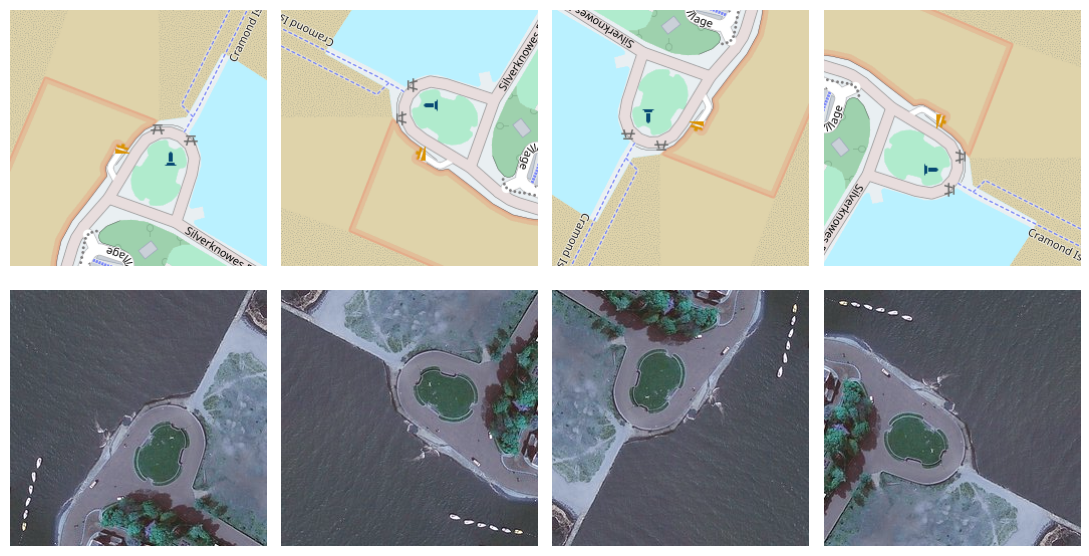

In [ ]:
# @title Augmentation by Rotation testing
fig, axes = plt.subplots(2, 4, figsize=(11, 6))
axes[0,0].imshow(cv2.imread('/content/openstreetmap/17_64334_40827.png'))
axes[1,0].imshow(cv2.imread('/content/worldimagery-clarity/17_64334_40827.png'))
axes[0, 0].axis('off')
axes[1, 0].axis('off')
for i in range(1,4):
  axes[0,i].imshow(np.rot90(cv2.imread('/content/openstreetmap/17_64334_40827.png'), k = i))
  axes[1,i].imshow(np.rot90(cv2.imread('/content/worldimagery-clarity/17_64334_40827.png'), k = i))
  axes[0, i].axis('off')
  axes[1, i].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# @title Dataset Loader with optional augmentation
# This classs overwrites torch Dataset, so that all the images are loaded into ram when creating the dataset
# avoiding the bottleneck created by retrieval from hard-disk
class InMemoryCustomDataset(Dataset):
    def __init__(self, source_dir, target_dir, transform=None, augment_rotation=False):
        self.source_dir = source_dir
        self.target_dir = target_dir
        self.source_images = []  # This holds the OpenStreetMaps
        self.target_images = []  # This holds real Satellite views
        self.transform = transform
        self.augment_rotation = augment_rotation
        self.load_images_into_memory()

    def load_images_into_memory(self):
        source_files = sorted(os.listdir(self.source_dir))
        target_files = sorted(os.listdir(self.target_dir))

        for source_img_name, target_img_name in zip(source_files, target_files):
            source_img_path = os.path.join(self.source_dir, source_img_name)
            target_img_path = os.path.join(self.target_dir, target_img_name)
            try:
                source_img = cv2.imread(source_img_path)
                source_img = cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB)
                source_img = cv2.resize(source_img, (128, 128), cv2.INTER_AREA)  # Resize to 128x128

                target_img = cv2.imread(target_img_path)
                target_img = cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB)
                target_img = cv2.resize(target_img, (128, 128), cv2.INTER_AREA)  # Resize to 128x128

                self.source_images.append(source_img)
                self.target_images.append(target_img)

                if self.augment_rotation:
                    # Perform rotations and append to the dataset, decide how many rotations (scale at will)
                    for angle in [90, 180, 270]:
                        rotated_source = np.array(np.rot90(source_img, k=int(angle / 90))) # Perform rotation by k*90 degrees
                        rotated_target = np.array(np.rot90(target_img, k=int(angle / 90)))
                        self.source_images.append(rotated_source)
                        self.target_images.append(rotated_target)

            except Exception as e: # Just for debugging, some images might be currupted
                print(f"Error loading image (skipped) at path {source_img_path} or {target_img_path}: {e}")

    def __len__(self):
        return len(self.source_images)

    def __getitem__(self, idx):
        source_img = self.source_images[idx]
        target_img = self.target_images[idx]

        if self.transform:
            source_img = self.transform(source_img)
            target_img = self.transform(target_img)

        return {'source_image': source_img, 'target_image': target_img}


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# source and target dir are the folders produced by unzipping
train_dataset = InMemoryCustomDataset(source_dir='/content/openstreetmap',
                                      target_dir='/content/worldimagery-clarity',
                                      transform=transform,
                                      augment_rotation=True)  # Data augmenation is true

# Set batch size
batch_size = 16

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
len(train_dataset)

20160

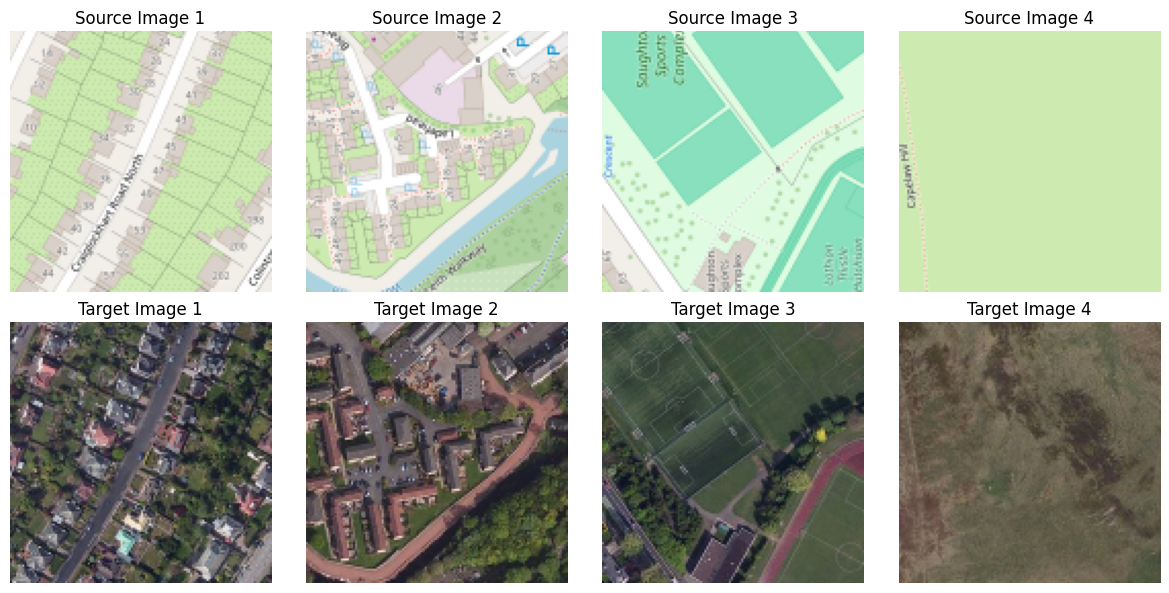

In [ ]:
# @title Random Samples Visualization
import matplotlib.pyplot as plt
import random

# Get four random indices from the dataset
num_samples = len(train_dataset)
indices = random.sample(range(num_samples), 4)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, idx in enumerate(indices):
    sample = train_dataset[idx]
    source_img = sample['source_image']
    target_img = sample['target_image']

    # Convert tensors to numpy arrays for visualization
    source_img = source_img.permute(1, 2, 0).numpy()  # Assuming tensor shape is (C, H, W)
    target_img = target_img.permute(1, 2, 0).numpy()  # Assuming tensor shape is (C, H, W)

    axes[0, i].imshow(source_img)
    axes[0, i].axis('off')
    axes[0, i].set_title(f'Source Image {i+1}')

    axes[1, i].imshow(target_img)
    axes[1, i].axis('off')
    axes[1, i].set_title(f'Target Image {i+1}')

plt.tight_layout()
plt.show()

# Small and Big Gans Training

In [ ]:
netD = Discriminator().cuda()
netG = Generator(num_classes=3).cuda()
OptimizerD = torch.optim.Adam(netD.parameters(),lr=0.00015)
OptimizerG = torch.optim.Adam(netG.parameters(),lr=0.00015)

BCE_Loss = nn.BCEWithLogitsLoss()
L1_Loss = nn.L1Loss() #MAE

In [ ]:
ch = torch.load(f'/content/drive/MyDrive/DataScotland/checkpointEpoch_379.pth')
netG.load_state_dict(ch['gen_state_dict'])
netD.load_state_dict(ch['disc_state_dict'])
OptimizerD.load_state_dict(ch['optimizerD_state_dict'])
OptimizerG.load_state_dict(ch['optimizerG_state_dict'])

In [ ]:
# @title SmallGen training
num_epochs = 380  # Define the number of epochs
G_lossHistory = ch['G_lossHistory']
D_lossHistory = ch['D_lossHistory']

scaler = torch.cuda.amp.GradScaler()

for epoch in range(191,num_epochs):
    # running loss for checking eventual collapse and later visualization
    running_lossG = 0.0
    running_lossD = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a dictionary containing source and target images
        x, y = data['source_image'], data['target_image']
        # Move images to the GPU
        x, y = x.to('cuda'), y.to('cuda')

        # Discriminator training
        with torch.cuda.amp.autocast():
          y_fake = netG(x)
          D_real = netD(x,y)
          D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real)) #matrix vs one-filled-matrix
          D_fake = netD(x,y_fake.detach())
          D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake)) # just 0
          D_loss = (D_real_loss + D_fake_loss)/2

        netD.zero_grad()
        scaler.scale(D_loss).backward()
        scaler.step(OptimizerD)
        scaler.update()

        # Generator training
        with torch.cuda.amp.autocast():
          D_fake = netD(x, y_fake)
          G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
          L1 = L1_Loss(y_fake, y) * 100 # L1-LAMBDA
          G_loss = G_fake_loss + L1

        OptimizerG.zero_grad()
        scaler.scale(G_loss).backward()
        scaler.step(OptimizerG)
        scaler.update()

        # Print statistics to check eventual collapses or vanished gradient
        running_lossG += G_loss.item()
        running_lossD += D_loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print('Epoch [{}/{}], Batch [{}/{}], G_Loss: {:.4f}, D_Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), running_lossG / 10, running_lossD / 10))

            G_lossHistory.append(running_lossG)
            D_lossHistory.append(running_lossD)
            running_lossG = 0.0
            running_lossD = 0.0

    checkpoint = {
      'epoch': epoch,
      'gen_state_dict': netG.state_dict(),
      'disc_state_dict': netD.state_dict(),
      'optimizerD_state_dict': OptimizerD.state_dict(),
      'optimizerG_state_dict': OptimizerG.state_dict(),
      'G_lossHistory': G_lossHistory,
      'D_lossHistory': D_lossHistory
      # Include other relevant information you want to save
    }
    checkpoint_path = f'/content/drive/MyDrive/DataScotland/checkpointEpoch_{epoch}.pth'
    torch.save(checkpoint, checkpoint_path)
    if epoch % 10 == 0:
      # Get a batch of images from the test loader
      data_iterator = iter(train_loader)
      images = next(data_iterator)

      # Extract source images
      source_images = images['source_image'][:6].to('cuda')

      # Generate target images from the source images using the generator
      with torch.no_grad():
          generated_targets = netG(source_images)

      # Visualize source and generated target images
      fig, axes = plt.subplots(2, 6, figsize=(14, 7))

      for i in range(6):
          source_img = source_images[i].cpu().permute(1, 2, 0)
          generated_img = generated_targets[i].cpu().permute(1, 2, 0)

          axes[0, i].imshow(source_img)
          #axes[0, i].set_title('Source Image')
          axes[0, i].axis('off')

          axes[1, i].imshow(generated_img)
          #axes[1, i].set_title('Generated Target Image')
          axes[1, i].axis('off')

      plt.tight_layout()
      plt.show()

print('Finished Training')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
netD = Discriminator().cuda()
netG = BigGen(num_classes=3).cuda()
OptimizerD = torch.optim.Adam(netD.parameters(),lr=0.0001)
OptimizerG = torch.optim.Adam(netG.parameters(),lr=0.0001)

BCE_Loss = nn.BCEWithLogitsLoss()
L1_Loss = nn.L1Loss() #MAE

In [ ]:
ch = torch.load(f'/content/drive/MyDrive/DataScotland/BigGenEp_549.pth')
netG.load_state_dict(ch['gen_state_dict'])
#netD.load_state_dict(ch['disc_state_dict'])
#OptimizerD.load_state_dict(ch['optimizerD_state_dict'])
OptimizerG.load_state_dict(ch['optimizerG_state_dict'])
scaler = torch.cuda.amp.GradScaler()
scaler.load_state_dict(ch['scaler_state_dict'])
G_lossHistory = ch['G_lossHistory']
D_lossHistory = ch['D_lossHistory']

In [ ]:
netG

BigGen(
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_convolution_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_convolution_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(

from ep 483 to 600: lr = 10^-5

In [ ]:
# @title BigGen Training
num_epochs = 600  # Define the number of epochs

for epoch in range(483,num_epochs):
    # Save the state of your model, optimizer, and other information
    running_lossG = 0.0
    running_lossD = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a dictionary containing source and target images
        x, y = data['source_image'], data['target_image']
        # Move the inputs to the GPU if available
        x, y = x.to('cuda'), y.to('cuda')

        ############## Train Discriminator ##############
        with torch.cuda.amp.autocast():
          y_fake = netG(x)
          D_real = netD(x,y)
          D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real)) #matrix vs one-filled-matrix
          D_fake = netD(x,y_fake.detach())
          D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake)) # just 0
          D_loss = (D_real_loss + D_fake_loss)/2

        netD.zero_grad()
        scaler.scale(D_loss).backward()
        scaler.step(OptimizerD)
        scaler.update()

        ############## Train Generator ##############
        with torch.cuda.amp.autocast():
          D_fake = netD(x, y_fake)
          G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
          L1 = L1_Loss(y_fake, y) * 100 # L1-LAMBDA
          G_loss = G_fake_loss + L1

        OptimizerG.zero_grad()
        scaler.scale(G_loss).backward()
        scaler.step(OptimizerG)
        scaler.update()

        # Print statistics
        running_lossG += G_loss.item()
        running_lossD += D_loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print('Epoch [{}/{}], Batch [{}/{}], G_Loss: {:.4f}, D_Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), running_lossG / 10, running_lossD / 10))

            G_lossHistory.append(running_lossG)
            D_lossHistory.append(running_lossD)
            running_lossG = 0.0
            running_lossD = 0.0

    checkpoint = {
      'epoch': epoch,
      'gen_state_dict': netG.state_dict(),
      'disc_state_dict': netD.state_dict(),
      'optimizerD_state_dict': OptimizerD.state_dict(),
      'optimizerG_state_dict': OptimizerG.state_dict(),
      'G_lossHistory': G_lossHistory,
      'D_lossHistory': D_lossHistory,
      'scaler_state_dict': scaler.state_dict()
      # Include other relevant information you want to save
    }
    checkpoint_path = f'/content/drive/MyDrive/DataScotland/BigGenEp_{epoch}.pth'
    torch.save(checkpoint, checkpoint_path)
    if epoch % 10 == 0:
      # Get a batch of images from the test loader
      data_iterator = iter(train_loader)
      images = next(data_iterator)

      # Extract source images
      source_images = images['source_image'][:6].to('cuda')

      # Generate target images from the source images using the generator
      with torch.no_grad():
          generated_targets = netG(source_images)

      # Visualize source and generated target images
      fig, axes = plt.subplots(2, 6, figsize=(14, 7))

      for i in range(6):
          source_img = source_images[i].cpu().permute(1, 2, 0)
          generated_img = generated_targets[i].cpu().permute(1, 2, 0)

          axes[0, i].imshow(source_img)
          #axes[0, i].set_title('Source Image')
          axes[0, i].axis('off')

          axes[1, i].imshow(generated_img)
          #axes[1, i].set_title('Generated Target Image')
          axes[1, i].axis('off')

      plt.tight_layout()
      plt.show()

print('Finished Training')


In [ ]:
smallG = Generator(num_classes=3)
small_ch = torch.load(f'/content/drive/MyDrive/DataScotland/checkpointEpoch_424.pth')
smallG.load_state_dict(small_ch['gen_state_dict'])

<All keys matched successfully>

Ind =  35


Ind =  152


Ind =  1013


Ind =  1081


Ind =  10044


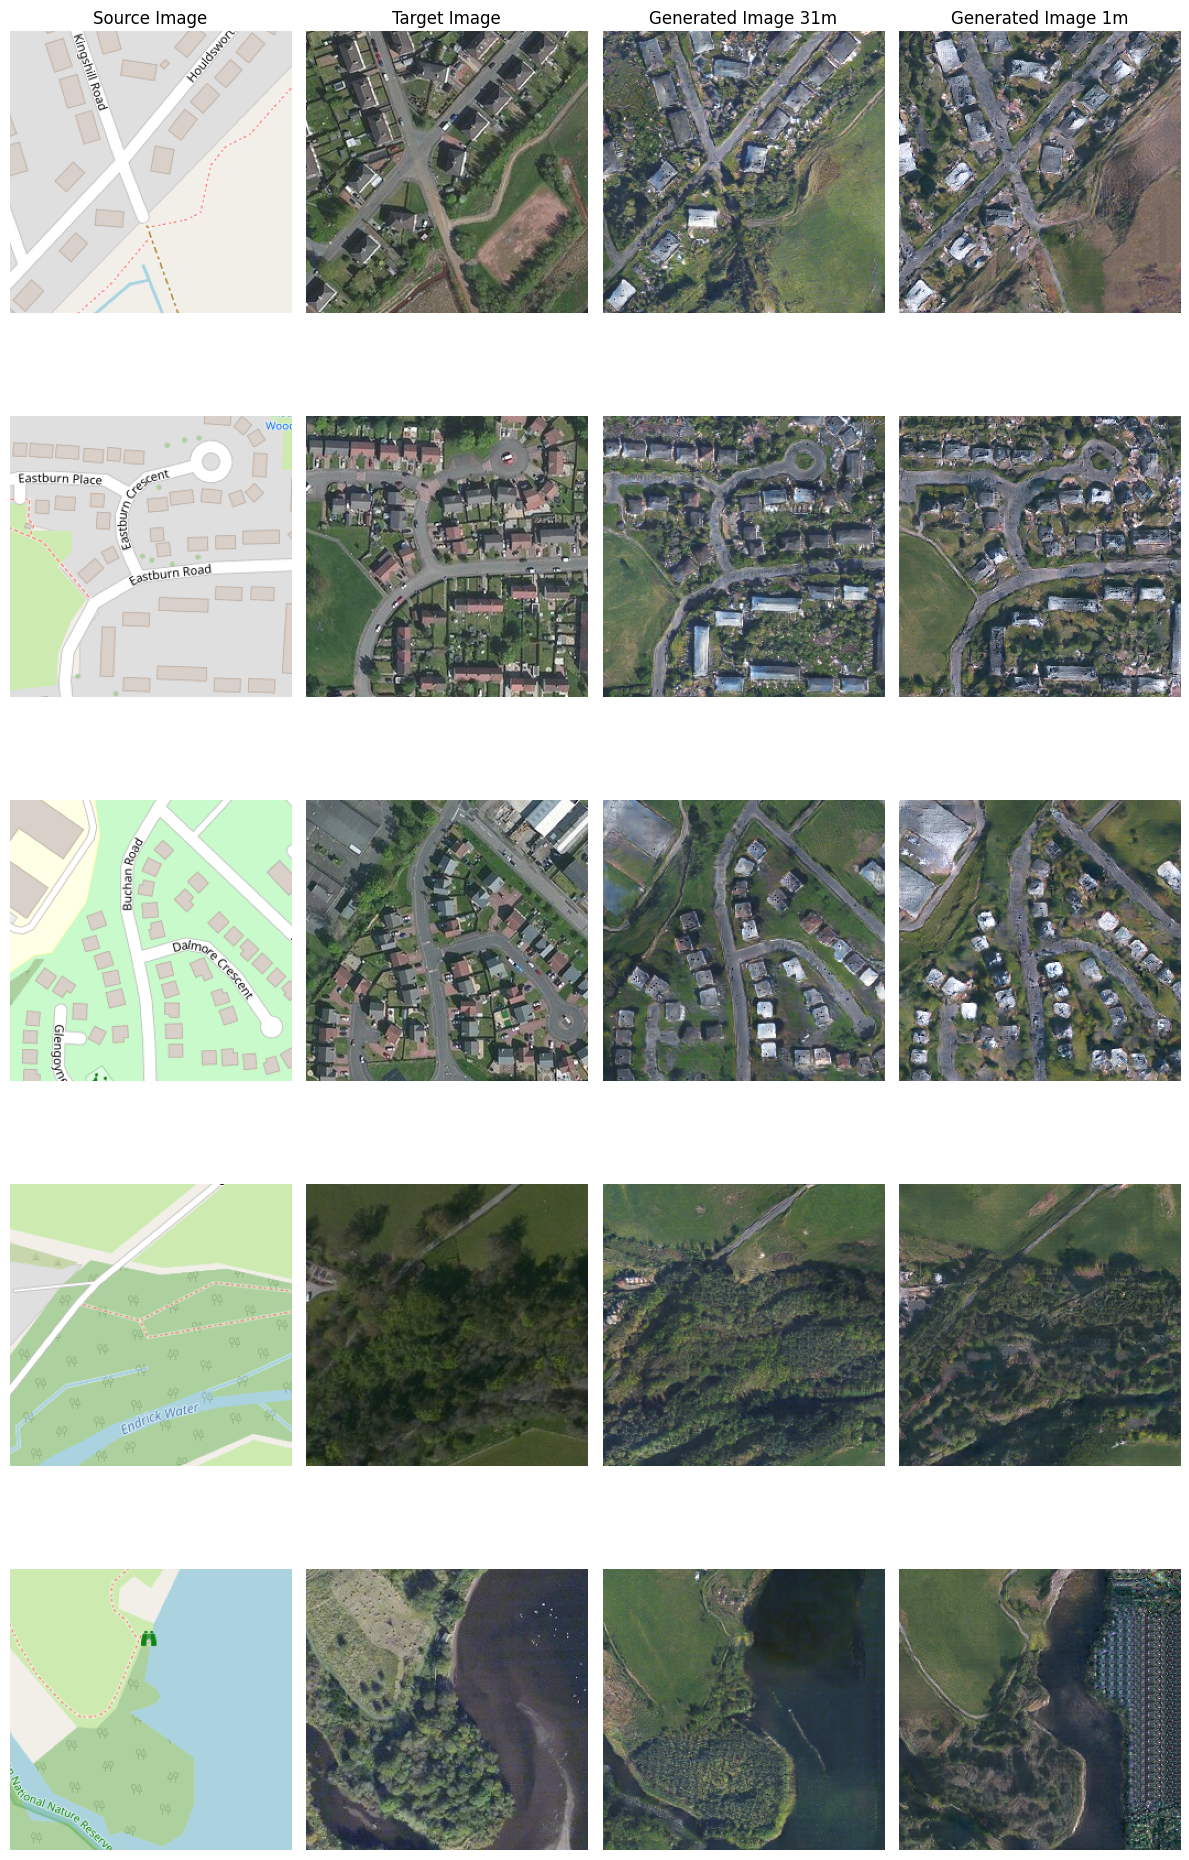

In [ ]:
# @title Original vs Big and Small Generator

# Paths to your images
image_paths = [
    '/content/tiles_central-belt50000/openstreetmap',
    '/content/tiles_central-belt50000/worldimagery-clarity',
]

ind_list = [35, 152, 1013, 1081, 10044]  # List of indices to display
num_images = len(ind_list)

fig, axes = plt.subplots(num_images, 4, figsize=(12, 4 * num_images))

for idx, ind in enumerate(ind_list):
    print('Ind = ', ind)
    # Load the first and second images
    img1_path = os.path.join(image_paths[0], os.listdir(image_paths[0])[ind])
    img2_path = os.path.join(image_paths[1], os.listdir(image_paths[1])[ind])

    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

    # Assuming netG is a pre-trained generator network in PyTorch
    # You'll need to replace this part with your actual generator network code
    # Preprocess the first image using the same transformations expected by the netG
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Convert images to PyTorch tensors and apply the same transformation used in the dataset
    img1_tensor = transform(img1)

    # Stack img1_tensor with an additional dimension to simulate batch size of 1
    input_tensor = torch.stack([img1_tensor])

    # Generate the third image using the netG
    with torch.no_grad():
        # Assuming netG is a pre-trained PyTorch model that takes input_tensor as input
        # Replace this with your actual netG forward pass
        generated_img_tensor = netG(input_tensor)  # Placeholder for generated image
        small_gen_img = smallG(input_tensor)

    # Convert the generated tensor back to a numpy array for visualization
    generated_img = generated_img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    small_gen_img = small_gen_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Plot each image in the corresponding row
    axes[idx, 0].imshow(img1)
    axes[idx, 0].axis('off')

    axes[idx, 1].imshow(img2)
    axes[idx, 1].axis('off')

    # Plot the generated image
    axes[idx, 2].imshow(generated_img)
    axes[idx, 2].axis('off')

    axes[idx, 3].imshow(small_gen_img)
    axes[idx, 3].axis('off')

axes[0, 0].set_title(f'Source Image')
axes[0, 1].set_title(f'Target Image')
axes[0, 2].set_title(f'Generated Image 31m')
axes[0, 3].set_title(f'Generated Image 1m')
plt.tight_layout()  # Adjust layout
plt.show()


indices good gen: 8, 21, 25, 33, 35!, 152!, 1010, 1013!, 1052v, 1081!v, 10044v!,


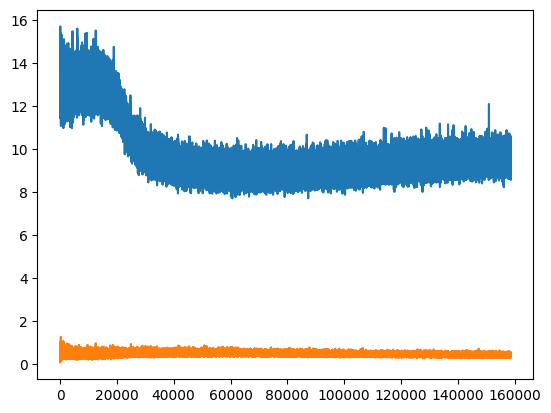

In [ ]:
plt.plot(np.array(G_lossHistory[10:])/10)
plt.plot(np.array(D_lossHistory[10:])/10)

# NEW DATASET only Edinburgh city (less green areas, more urban, more balanced)

In [ ]:
!unzip /content/drive/MyDrive/DataScotland/tiles_edi20000.zip > /dev/null

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Replace 'source_folder' and 'target_folder' with your actual folder paths
train_dataset = InMemoryCustomDataset(source_dir='/content/openstreetmap',
                                      target_dir='/content/worldimagery-clarity',
                                      transform=transform,
                                      augment_rotation=False)  # Set augment_rotation to True

# Set batch size
batch_size = 16

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
len(train_dataset)

5040

In [ ]:
netD = Discriminator().cuda()
netG = BigGen(num_classes=3).cuda()
OptimizerD = torch.optim.Adam(netD.parameters(),lr=0.0001)
OptimizerG = torch.optim.Adam(netG.parameters(),lr=0.0001)

BCE_Loss = nn.BCEWithLogitsLoss()
L1_Loss = nn.L1Loss() #MAE
scaler = torch.cuda.amp.GradScaler()

In [ ]:
ch = torch.load(f'/content/drive/MyDrive/DataScotland/EdiModels/EdiBigGenEp_670.pth')
netG.load_state_dict(ch['gen_state_dict'])
netD.load_state_dict(ch['disc_state_dict'])
OptimizerD.load_state_dict(ch['optimizerD_state_dict'])
OptimizerG.load_state_dict(ch['optimizerG_state_dict'])
scaler.load_state_dict(ch['scaler_state_dict'])
G_lossHistory = ch['G_lossHistory']
D_lossHistory = ch['D_lossHistory']

In [ ]:
# @title Training Edinburgh Dataset
num_epochs = 701 # Define the number of epochs

for epoch in range(601, num_epochs):
    # Save the state of your model, optimizer, and other information
    running_lossG = 0.0
    running_lossD = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a dictionary containing source and target images
        x, y = data['source_image'], data['target_image']
        # Move the inputs to the GPU if available
        x, y = x.to('cuda'), y.to('cuda')

        ############## Train Discriminator ##############
        with torch.cuda.amp.autocast():
          y_fake = netG(x)
          D_real = netD(x,y)
          D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real)) #matrix vs one-filled-matrix
          D_fake = netD(x,y_fake.detach())
          D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake)) # just 0
          D_loss = (D_real_loss + D_fake_loss)/2

        netD.zero_grad()
        scaler.scale(D_loss).backward()
        scaler.step(OptimizerD)
        scaler.update()

        ############## Train Generator ##############
        with torch.cuda.amp.autocast():
          D_fake = netD(x, y_fake)
          G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
          L1 = L1_Loss(y_fake, y) * 100 # L1-LAMBDA
          G_loss = G_fake_loss + L1

        OptimizerG.zero_grad()
        scaler.scale(G_loss).backward()
        scaler.step(OptimizerG)
        scaler.update()

        # Print statistics
        running_lossG += G_loss.item()
        running_lossD += D_loss.item()
        if i % 20 == 19:    # Print every 10 mini-batches
            print('Epoch [{}/{}], Batch [{}/{}], G_Loss: {:.4f}, D_Loss: {:.4f}'.format(epoch + 1, num_epochs, i + 1, len(train_loader), running_lossG / 20, running_lossD / 20))

            G_lossHistory.append(running_lossG)
            D_lossHistory.append(running_lossD)
            running_lossG = 0.0
            running_lossD = 0.0

    if epoch % 10 == 0:
      checkpoint = {
        'epoch': epoch,
        'gen_state_dict': netG.state_dict(),
        'disc_state_dict': netD.state_dict(),
        'optimizerD_state_dict': OptimizerD.state_dict(),
        'optimizerG_state_dict': OptimizerG.state_dict(),
        'G_lossHistory': G_lossHistory,
        'D_lossHistory': D_lossHistory,
        'scaler_state_dict': scaler.state_dict()
        # Include other relevant information you want to save
      }
      checkpoint_path = f'/content/drive/MyDrive/DataScotland/EdiModels/EdiBigGenEp_{epoch}.pth'
      torch.save(checkpoint, checkpoint_path)

      # Get a batch of images from the test loader
      data_iterator = iter(train_loader)
      images = next(data_iterator)

      # Extract source images
      source_images = images['source_image'][:6].to('cuda')

      # Generate target images from the source images using the generator
      with torch.no_grad():
          generated_targets = netG(source_images)

      # Visualize source and generated target images
      fig, axes = plt.subplots(2, 6, figsize=(14, 7))

      for i in range(6):
          source_img = source_images[i].cpu().permute(1, 2, 0)
          generated_img = generated_targets[i].cpu().permute(1, 2, 0)

          axes[0, i].imshow(source_img)
          #axes[0, i].set_title('Source Image')
          axes[0, i].axis('off')

          axes[1, i].imshow(generated_img)
          #axes[1, i].set_title('Generated Target Image')
          axes[1, i].axis('off')

      plt.tight_layout()
      plt.show()

print('Finished Training')


Output hidden; open in https://colab.research.google.com to view.

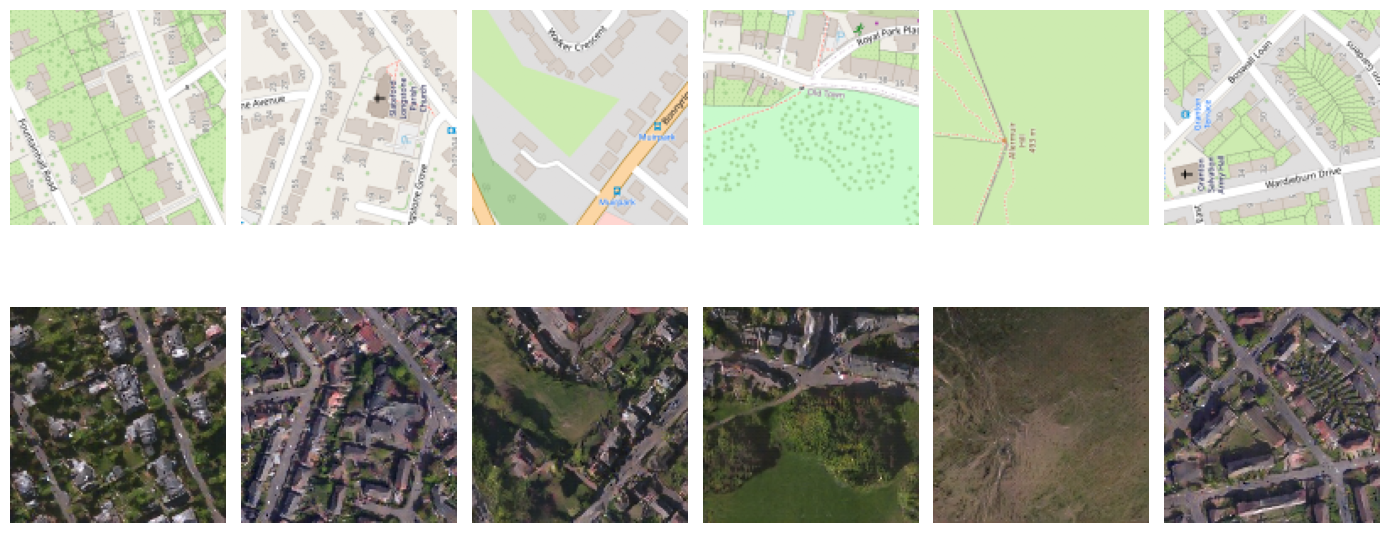

In [ ]:
# Get a batch of images from the test loader
data_iterator = iter(train_loader)
images = next(data_iterator)

# Extract source images
source_images = images['source_image'][:6].to('cuda')

# Generate target images from the source images using the generator
with torch.no_grad():
    generated_targets = netG(source_images)

# Visualize source and generated target images
fig, axes = plt.subplots(2, 6, figsize=(14, 7))

for i in range(6):
    source_img = source_images[i].cpu().permute(1, 2, 0)
    generated_img = generated_targets[i].cpu().permute(1, 2, 0)

    axes[0, i].imshow(source_img)
    #axes[0, i].set_title('Source Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(generated_img)
    #axes[1, i].set_title('Generated Target Image')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
checkpoint = {
  'epoch': epoch,
  'gen_state_dict': netG.state_dict(),
  'disc_state_dict': netD.state_dict(),
  'optimizerD_state_dict': OptimizerD.state_dict(),
  'optimizerG_state_dict': OptimizerG.state_dict(),
  'G_lossHistory': G_lossHistory,
  'D_lossHistory': D_lossHistory,
  'scaler_state_dict': scaler.state_dict()
  # Include other relevant information you want to save
}

checkpoint_path = f'/content/drive/MyDrive/DataScotland/EdiModels/EdiBigGenEp_{epoch}.pth'
torch.save(checkpoint, checkpoint_path)

In [ ]:
# @title ComplexGen : BigGen + Dropout, batchnorm, leakyrelu

def double_convolution(in_channels, out_channels):
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.InstanceNorm2d(out_channels),  # Adding BatchNorm layer
        nn.LeakyReLU(inplace=True),   # Using LeakyReLU instead of ReLU
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.InstanceNorm2d(out_channels),  # Adding BatchNorm layer
        nn.LeakyReLU(inplace=True)    # Using LeakyReLU instead of ReLU
    )
    return conv_op

class ComplexGen(nn.Module):
    def __init__(self, num_classes):
        super(ComplexGen, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(3, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        self.dropout = nn.Dropout2d(p=0.2)  # Define dropout layer with 20% probability

        # Expanding path.
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        # Below, `in_channels` again becomes 1024 as we are concatinating.
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.dropout( self.max_pool2d(down_5) )
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.dropout( self.max_pool2d(down_7) )
        down_9 = self.down_convolution_5(down_8)
        # *** DO NOT APPLY MAX POOL TO down_9 ***

        up_1 = self.up_transpose_1(down_9)
        x = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        x = self.dropout(x)
        up_2 = self.up_transpose_2(x)
        x = self.up_convolution_2(torch.cat([down_5, up_2], 1))
        x = self.dropout(x)
        up_3 = self.up_transpose_3(x)
        x = self.up_convolution_3(torch.cat([down_3, up_3], 1))
        up_4 = self.up_transpose_4(x)
        x = self.up_convolution_4(torch.cat([down_1, up_4], 1))
        out = self.out(x)
        return out


In [ ]:
netD = Discriminator().cuda()
netG = ComplexGen(num_classes=3).cuda()
OptimizerD = torch.optim.Adam(netD.parameters(),lr=0.0001)
OptimizerG = torch.optim.Adam(netG.parameters(),lr=0.0001)

BCE_Loss = nn.BCEWithLogitsLoss().cuda()
L1_Loss = nn.L1Loss().cuda() #MAE
scaler = torch.cuda.amp.GradScaler()

In [ ]:
ch = torch.load(f'/content/drive/MyDrive/DataScotland/EdiModels/Edi_ComplexGen_130.pth')
netG.load_state_dict(ch['gen_state_dict'])
netD.load_state_dict(ch['disc_state_dict'])
OptimizerD.load_state_dict(ch['optimizerD_state_dict'])
OptimizerG.load_state_dict(ch['optimizerG_state_dict'])
scaler.load_state_dict(ch['scaler_state_dict'])
G_lossHistory = ch['G_lossHistory']
D_lossHistory = ch['D_lossHistory']

In [ ]:
# @title training complex generator
num_epochs = 500 # Define the number of epochs

for epoch in range(131, num_epochs + 1):
    # Save the state of your model, optimizer, and other information
    running_lossG = 0.0
    running_lossD = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a dictionary containing source and target images
        x, y = data['source_image'], data['target_image']
        # Move the inputs to the GPU if available
        x, y = x.to('cuda'), y.to('cuda')

        ############## Train Discriminator ##############
        with torch.cuda.amp.autocast():
          y_fake = netG(x)
          D_real = netD(x,y)
          D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real)) #matrix vs one-filled-matrix
          D_fake = netD(x,y_fake.detach())
          D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake)) # just 0
          D_loss = (D_real_loss + D_fake_loss)/2

        netD.zero_grad()
        scaler.scale(D_loss).backward()
        scaler.step(OptimizerD)
        scaler.update()

        ############## Train Generator ##############
        with torch.cuda.amp.autocast():
          D_fake = netD(x, y_fake)
          G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
          L1 = L1_Loss(y_fake, y) * 100 # L1-LAMBDA
          G_loss = G_fake_loss + L1

        OptimizerG.zero_grad()
        scaler.scale(G_loss).backward()
        scaler.step(OptimizerG)
        scaler.update()

        # Print statistics
        running_lossG += G_loss.item()
        running_lossD += D_loss.item()
        if i % 20 == 19:    # Print every 10 mini-batches
            print('Epoch [{}/{}], Batch [{}/{}], G_Loss: {:.4f}, D_Loss: {:.4f}'.format(epoch, num_epochs, i + 1, len(train_loader), running_lossG / 20, running_lossD / 20))

            G_lossHistory.append(running_lossG)
            D_lossHistory.append(running_lossD)
            running_lossG = 0.0
            running_lossD = 0.0

    if epoch % 10 == 0:
      checkpoint = {
        'epoch': epoch,
        'gen_state_dict': netG.state_dict(),
        'disc_state_dict': netD.state_dict(),
        'optimizerD_state_dict': OptimizerD.state_dict(),
        'optimizerG_state_dict': OptimizerG.state_dict(),
        'G_lossHistory': G_lossHistory,
        'D_lossHistory': D_lossHistory,
        'scaler_state_dict': scaler.state_dict()
        # Include other relevant information you want to save
      }
      checkpoint_path = f'/content/drive/MyDrive/DataScotland/EdiModels/Edi_ComplexGen_{epoch}.pth'
      torch.save(checkpoint, checkpoint_path)

      # Get a batch of images from the test loader
      data_iterator = iter(train_loader)
      images = next(data_iterator)

      # Extract source images
      source_images = images['source_image'][:6].to('cuda')

      # Generate target images from the source images using the generator
      with torch.no_grad():
          generated_targets = netG(source_images)

      # Visualize source and generated target images
      fig, axes = plt.subplots(2, 6, figsize=(14, 7))

      for i in range(6):
          source_img = source_images[i].cpu().permute(1, 2, 0)
          generated_img = generated_targets[i].cpu().permute(1, 2, 0)

          axes[0, i].imshow(source_img)
          #axes[0, i].set_title('Source Image')
          axes[0, i].axis('off')

          axes[1, i].imshow(generated_img)
          #axes[1, i].set_title('Generated Target Image')
          axes[1, i].axis('off')

      plt.tight_layout()
      plt.show()

print('Finished Training')


# Refinement network

In [ ]:
netD = Discriminator().cuda()
netG = BigGen(num_classes=3).cuda()
ch = torch.load(f'/content/drive/MyDrive/DataScotland/EdiModels/EdiBigGenEp_670.pth')
netG.load_state_dict(ch['gen_state_dict'])

<All keys matched successfully>

In [ ]:
# @title Creating new refinement dataset and save to storage
import torchvision.transforms.functional as TF

# Create folders to save the generated images and real targets
generated_folder = '/content/5000generated_images'
real_target_folder = '/content/5000real_targets'

os.makedirs(generated_folder, exist_ok=True)
os.makedirs(real_target_folder, exist_ok=True)

# Loop through the source images in the existing dataset
for idx in range(len(train_dataset)):
    sample = train_dataset[idx]
    source_img = sample['source_image'].unsqueeze(0).cuda()  # Assuming the source image is a PyTorch tensor

    # Generate the target image using your generator
    with torch.no_grad():
        generated_img = netG(source_img)

    # Convert the generated image (PyTorch tensor) to a PIL Image
    generated_img_pil = TF.to_pil_image(generated_img.squeeze(0).cpu())

    # Convert the target image (PyTorch tensor) to a PIL Image
    target_img_pil = TF.to_pil_image(sample['target_image'].cpu())

    # Generate filenames
    generated_filename = f"generated_{idx}.png"
    real_target_filename = f"real_target_{idx}.png"

    # Save the generated image and real target image
    generated_img_pil.save(os.path.join(generated_folder, generated_filename))
    target_img_pil.save(os.path.join(real_target_folder, real_target_filename))



In [ ]:
#  @title Resnet (IGNORE: discarded, not good)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual  # Adding residual connection
        out = self.relu(out)
        return out

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, padding=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            ResidualBlock(64, 64),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            ResidualBlock(128, 128),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),  # Upsample with stride=2
            nn.ReLU(inplace=True),
            ResidualBlock(128, 128),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),  # Upsample with stride=2
            nn.ReLU(inplace=True),
            ResidualBlock(64, 64),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # Upsample with stride=2
            nn.ReLU(inplace=True),
            ResidualBlock(32, 32),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2),  # Upsample with stride=2
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size = 1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model
netAE = AutoEncoder()

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Replace 'source_folder' and 'target_folder' with your actual folder paths
train_dataset = InMemoryCustomDataset(source_dir='/content/5000generated_images',
                                      target_dir='/content/5000real_targets',
                                      transform=transform,
                                      augment_rotation=False)  # Set augment_rotation to True

In [ ]:
# Set batch size
batch_size = 16

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [ ]:
len(train_dataset)

5040

In [ ]:
netD = Discriminator().cuda()
netG = BigGen(num_classes=3).cuda()
OptimizerD = torch.optim.Adam(netD.parameters(),lr=0.0001)
OptimizerG = torch.optim.Adam(netG.parameters(),lr=0.0001)

BCE_Loss = nn.BCEWithLogitsLoss().cuda()
L1_Loss = nn.L1Loss().cuda() #MAE
scaler = torch.cuda.amp.GradScaler()

In [ ]:
ch = torch.load(f'/content/drive/MyDrive/DataScotland/EdiModels/Edi_RefDivergence_400.pth')
netG.load_state_dict(ch['gen_state_dict'])
netD.load_state_dict(ch['disc_state_dict'])
OptimizerD.load_state_dict(ch['optimizerD_state_dict'])
OptimizerG.load_state_dict(ch['optimizerG_state_dict'])
G_lossHistory = ch['G_lossHistory']
D_lossHistory = ch['D_lossHistory']
scaler.load_state_dict(ch['scaler_state_dict'])

In [ ]:
sum(p.numel() for p in netG.parameters() if p.requires_grad)

31031875

from ep 400 lr = 0.00005

In [ ]:
# @title Training ref Pix2Pix
num_epochs = 700 # Define the number of epochs

for epoch in range(401, num_epochs + 1):
    # Save the state of your model, optimizer, and other information
    running_lossG = 0.0
    running_lossD = 0.0
    for i, data in enumerate(train_loader, 0):
        # Get the inputs; data is a dictionary containing source and target images
        x, y = data['source_image'], data['target_image']
        # Move the inputs to the GPU if available
        x, y = x.to('cuda'), y.to('cuda')

        ############## Train Discriminator ##############
        with torch.cuda.amp.autocast():
          y_fake = netG(x)
          D_real = netD(x,y)
          D_real_loss = BCE_Loss(D_real, torch.ones_like(D_real)) #matrix vs one-filled-matrix
          D_fake = netD(x,y_fake.detach())
          D_fake_loss = BCE_Loss(D_fake, torch.zeros_like(D_fake)) # just 0
          D_loss = (D_real_loss + D_fake_loss)/2

        netD.zero_grad()
        scaler.scale(D_loss).backward()
        scaler.step(OptimizerD)
        scaler.update()

        ############## Train Generator ##############
        with torch.cuda.amp.autocast():
          D_fake = netD(x, y_fake)
          G_fake_loss = BCE_Loss(D_fake, torch.ones_like(D_fake))
          L1 = L1_Loss(y_fake, y) * 100 # L1-LAMBDA
          L1_opposite = L1_Loss(x, y_fake) * 10
          G_loss = G_fake_loss + L1 - L1_opposite

        OptimizerG.zero_grad()
        scaler.scale(G_loss).backward()
        scaler.step(OptimizerG)
        scaler.update()

        # Print statistics
        running_lossG += G_loss.item()
        running_lossD += D_loss.item()
        if i % 20 == 19:    # Print every 10 mini-batches
            print('Epoch [{}/{}], Batch [{}/{}], G_Loss: {:.4f}, D_Loss: {:.4f}'.format(epoch, num_epochs, i + 1, len(train_loader), running_lossG / 20, running_lossD / 20))

            G_lossHistory.append(running_lossG)
            D_lossHistory.append(running_lossD)
            running_lossG = 0.0
            running_lossD = 0.0

    if epoch % 10 == 0:
      checkpoint = {
        'epoch': epoch,
        'gen_state_dict': netG.state_dict(),
        'disc_state_dict': netD.state_dict(),
        'optimizerD_state_dict': OptimizerD.state_dict(),
        'optimizerG_state_dict': OptimizerG.state_dict(),
        'G_lossHistory': G_lossHistory,
        'D_lossHistory': D_lossHistory,
        'scaler_state_dict': scaler.state_dict()
        # Include other relevant information you want to save
      }
      checkpoint_path = f'/content/drive/MyDrive/DataScotland/EdiModels/Edi_RefDivergence_{epoch}.pth'
      torch.save(checkpoint, checkpoint_path)

      # Get a batch of images from the test loader
      data_iterator = iter(train_loader)
      images = next(data_iterator)

      # Extract source images
      source_images = images['source_image'][:6].to('cuda')
      target_images = images['target_image'][:6].to('cuda')

      # Generate target images from the source images using the generator
      with torch.no_grad():
          generated_targets = netG(source_images)

      # Visualize source and generated target images
      fig, axes = plt.subplots(3, 6, figsize=(14, 7))

      for i in range(6):
          source_img = source_images[i].cpu().permute(1, 2, 0)
          generated_img = generated_targets[i].cpu().permute(1, 2, 0)
          target_img = target_images[i].cpu().permute(1, 2, 0)

          axes[0, i].imshow(source_img)
          #axes[0, i].set_title('Source Image')
          axes[0, i].axis('off')

          axes[1, i].imshow(generated_img)
          #axes[1, i].set_title('Generated Target Image')
          axes[1, i].axis('off')

          axes[2, i].imshow(target_img)
          axes[2, i].axis('off')

      plt.tight_layout()
      plt.show()

print('Finished Training')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
checkpoint = {
  'epoch': epoch,
  'AE_state_dict': netAE.state_dict(),
  'optimizer_state_dict': optimizer.state_dict(),
}
checkpoint_path = f'/content/drive/MyDrive/DataScotland/EdiModels/Edi_RefUnet_{epoch}.pth'
torch.save(checkpoint, checkpoint_path)

In [ ]:
# Get a batch of images from the test loader
data_iterator = iter(train_loader)
images = next(data_iterator)

# Extract source images
source_images = images['source_image'][:6].to('cuda')
target_images = images['target_image'][:6].to('cuda')

# Generate target images from the source images using the generator
with torch.no_grad():
    generated_targets = netG(source_images)

# Visualize source and generated target images
fig, axes = plt.subplots(3, 6, figsize=(14, 7))

for i in range(6):
    source_img = source_images[i].cpu().permute(1, 2, 0)
    generated_img = generated_targets[i].cpu().permute(1, 2, 0)
    target_img = target_images[i].cpu().permute(1, 2, 0)

    axes[0, i].imshow(source_img)
    #axes[0, i].set_title('Source Image')
    axes[0, i].axis('off')

    axes[1, i].imshow(generated_img)
    #axes[1, i].set_title('Generated Target Image')
    axes[1, i].axis('off')

    axes[2, i].imshow(target_img)
    #axes[1, i].set_title('Generated Target Image')
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

#Test Evaluations

In [ ]:
!unzip /content/drive/MyDrive/TestSetEdi/test_tiles_edi.zip > /dev/null

In [ ]:
#@title Load models and test set for evaluation.
BigGeneratorEv = BigGen(num_classes=3).cuda()
RefinementGenerator = BigGen(num_classes=3).cuda()
cp_BigGen = torch.load("/content/drive/MyDrive/DataScotland/EdiModels/EdiBigGenEp_670.pth")
cp_RefGen = torch.load("/content/drive/MyDrive/DataScotland/EdiModels/Edi_RefDivergence_700.pth")
BigGeneratorEv.load_state_dict(cp_BigGen['gen_state_dict'])
RefinementGenerator.load_state_dict(cp_RefGen['gen_state_dict'])

# Set the models to evaluation mode
BigGeneratorEv.eval()
RefinementGenerator.eval()

# Sequential model
double_model = nn.Sequential(
    BigGeneratorEv,
    RefinementGenerator
)

# Move the sequential model to GPU if available
double_model = double_model.cuda()

transform = transforms.Compose([
    transforms.ToTensor(),
])

# Replace 'source_folder' and 'target_folder' with your actual folder paths
test_dataset = InMemoryCustomDataset(source_dir='/content/tiles_edi1000/openstreetmap',
                                      target_dir='/content/tiles_edi1000/worldimagery-clarity',
                                      transform=transform,
                                      augment_rotation=False)  # Set augment_rotation to True

print("Number of test images: ", len(test_dataset))

Number of test images:  910


In [ ]:
#@title Testing Function
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def evaluate_model(model, test_dataset, batch_size=32):
    # Set the model to evaluation mode
    model.eval()

    # DataLoader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize variables to accumulate the total metrics
    total_mse = 0.0
    total_ssim = 0.0
    total_psnr = 0.0

    # Iterate over the test dataset
    for batch in test_dataloader:
        # Move input images to GPU if available
        source_images = batch['source_image'].cuda()

        # Forward pass through the model
        with torch.no_grad():
            generated_images = model(source_images)

        # Move target images to GPU if available
        target_images = batch['target_image'].cuda()

        # Compute MSE for each pair of generated and target images
        mse_batch = F.mse_loss(generated_images, target_images, reduction='sum')

        # Compute SSIM for each pair of generated and target images
        for i in range(generated_images.shape[0]):
            ssim_batch = ssim(target_images[i].cpu().numpy().transpose((1, 2, 0)),
                              generated_images[i].cpu().numpy().transpose((1, 2, 0)),
                              channel_axis=2)
            total_ssim += ssim_batch

        # Compute PSNR for each pair of generated and target images
        for i in range(generated_images.shape[0]):
            psnr_batch = psnr(target_images[i].cpu().numpy().transpose((1, 2, 0)),
                              generated_images[i].cpu().numpy().transpose((1, 2, 0)),
                              data_range=1)
            total_psnr += psnr_batch

        # Accumulate the MSE
        total_mse += mse_batch.item()

    # Calculate the average metrics over all batches
    average_mse = total_mse / len(test_dataset)
    average_ssim = total_ssim / len(test_dataset)
    average_psnr = total_psnr / len(test_dataset)

    return average_mse, average_ssim, average_psnr

In [ ]:
average_mse, average_ssim, average_psnr = evaluate_model(BigGeneratorEv, test_dataset)
print(f'Average MSE on the test dataset: {average_mse}')
print(f'Average SSIM on the test dataset: {average_ssim}')
print(f'Average PSNR on the test dataset: {average_psnr}')

Average MSE on the test dataset: 558.4205797132555
Average SSIM on the test dataset: 0.5591230187442277
Average PSNR on the test dataset: 20.396874454511106


In [ ]:
average_mse, average_ssim, average_psnr = evaluate_model(double_model, test_dataset)
print(f'Average MSE on the test dataset: {average_mse}')
print(f'Average SSIM on the test dataset: {average_ssim}')
print(f'Average PSNR on the test dataset: {average_psnr}')

Average MSE on the test dataset: 342.3967505151099
Average SSIM on the test dataset: 0.6847702587698842
Average PSNR on the test dataset: 22.608390264568317


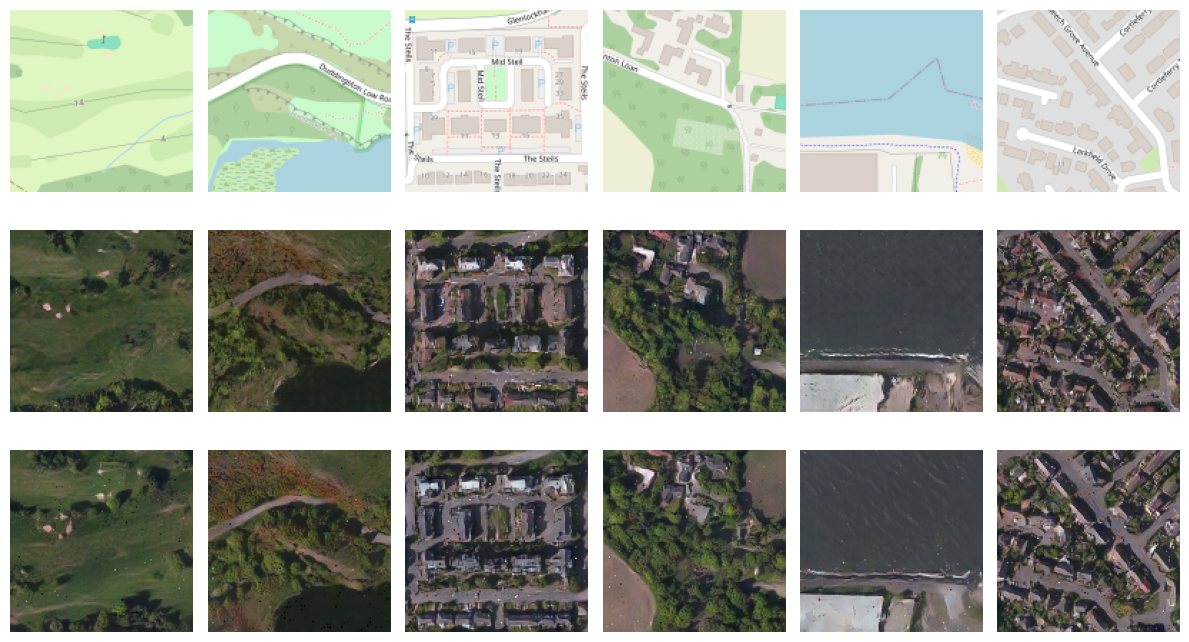

In [ ]:
# @title Test images Show-Off
# Get a batch of images from the test loader
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=True)
data_iterator = iter(test_loader)
images = next(data_iterator)

# Extract source images
source_images = images['source_image'].to('cuda')
# Generate target imgs using source imgs with both models, BigGen and BigGen+Refinement
with torch.no_grad():
    gen_no_ref = BigGeneratorEv(source_images)
    generated_targets = double_model(source_images)

# Plot everything, rows: source; BigGen; BigGen + Refinement
fig, axes = plt.subplots(3, 6, figsize=(12, 7))

for i in range(6):
    source_img = source_images[i].cpu().permute(1, 2, 0)
    gen_img = gen_no_ref[i].cpu().permute(1, 2, 0)
    gen_img_ref = generated_targets[i].cpu().permute(1, 2, 0)

    axes[0, i].imshow(source_img)
    axes[0, i].axis('off')
    axes[1, i].imshow(np.clip(gen_img, 0, 1))
    axes[1, i].axis('off')
    axes[2, i].imshow(np.clip(gen_img_ref, 0, 1))
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()